# Débruitage d'image : 
    Notebook de préparation de la donnée : bruitage et sauvegarde.

## Step 1 - Imports

In [25]:
# Import des bibliothèques
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

import os
## Remettre la ligne pour utiliser le backend Jax et tester si ca marche de nouveau
os.environ["KERAS_BACKEND"] = "jax"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  # Suppression des avertissements de TensorFlow
from keras import layers
from keras.models import Model
from huggingface_hub import from_pretrained_keras
import cv2
from PIL import Image
import glob
from tqdm.notebook import tqdm
import random
from sklearn.model_selection import train_test_split
import time
from skimage.metrics import structural_similarity as ssim
import shutil
from pathlib import Path
from keras.applications import VGG19
from keras.models import Model
from keras import backend as K
import tensorflow as tf


print("Versions des bibliothèques:")
print(f"TensorFlow: {tf.__version__}")
print(f"Keras: {keras.__version__}")


Versions des bibliothèques:
TensorFlow: 2.19.0
Keras: 3.9.0


## EDA

In [ ]:
## Est conduite dans la cellule suivante

## Step 2 - Paramètres et copie sur WSL (du dataset raw)

In [29]:
# Configuration des paramètres globaux

NOISE_LEVEL = 0.5     # Niveau de bruit global (0.05 = très faible, 0.1 = faible, 0.2 = moyen, 0.5 = fort, 1-2 : très fort)
NOISE_TYPE = "salt_pepper"  # Type de bruit: "gaussian", "salt_pepper", ou "speckle"
IMAGE_SIZE = 256      # Taille des images
BATCH_SIZE = 16       # Taille du batch
SEED = 42            # Seed pour la reproducibilité

np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

# Définir les chemins d'accès
WINDOWS_DIR = '/mnt/c/Users/NyveK/Downloads/Datasets/Datasets/livrable2/Dataset'
TARGET_WSL_L1_DIR = '/home/kevin/datasets/livrable1/raw/Photo'
TARGET_WSL_DIR = '/home/kevin/datasets/livrable2/raw'
TARGET_PROCESSED_L2_DIR = '/home/kevin/datasets/livrable2/raw'
TARGET_PROCESSED_DIR = '/home/kevin/datasets/livrable2/processed'

# Vérifier si le chemin Windows existe
windows_exists = os.path.exists(WINDOWS_DIR)
print(f"Le chemin Windows existe: {windows_exists}")

# Créer les dossiers de destination s'ils n'existent pas
Path(TARGET_WSL_DIR).mkdir(parents=True, exist_ok=True)
Path(TARGET_PROCESSED_DIR).mkdir(parents=True, exist_ok=True)

# Copier les données uniquement si le chemin source existe
if windows_exists:
    print(f"Copie des données depuis {WINDOWS_DIR} vers {TARGET_WSL_DIR}...")
    try:
        shutil.copytree(WINDOWS_DIR, TARGET_WSL_DIR, dirs_exist_ok=True)
        print("Copie terminée avec succès!")
    except Exception as e:
        print(f"Erreur lors de la copie: {e}")
else:
    print(f"ATTENTION: Le chemin source {WINDOWS_DIR} n'existe pas!")
    print("Veuillez vérifier le chemin et le monter correctement dans WSL.")
    print("Utilisation du chemin WSL directement s'il existe déjà...")

# Utiliser TARGET_WSL_DIR comme chemin de base s'il existe et contient des données
BASE_DIR = TARGET_WSL_DIR if os.path.exists(TARGET_WSL_DIR) and os.listdir(TARGET_WSL_DIR) else None

# Avertir l'utilisateur si aucun chemin valide n'est trouvé
if BASE_DIR is None:
    print("Aucun chemin valide trouvé pour les données. Le code utilisera des données de démonstration.")


print(f"Configuration : NOISE_LEVEL={NOISE_LEVEL}, NOISE_TYPE={NOISE_TYPE}, IMAGE_SIZE={IMAGE_SIZE}x{IMAGE_SIZE}")

# EDA (Exploratory Data Analysis)
# Compter le nombre d'images dans le dossier source
if BASE_DIR:
    image_files = [f for f in os.listdir(BASE_DIR) if f.endswith('.jpg') or f.endswith('.png')]
    num_images = len(image_files)
    print(f"Nombre d'images dans le dossier source : {num_images}")
else:
    print("Aucun dossier source valide trouvé. Aucune image à compter.")


# Print des informations sur les dataset copiés
print(f"Contenu du dossier source : {os.listdir(BASE_DIR) if BASE_DIR else 'Aucun contenu'}")
print(f"Contenu du dossier cible : {os.listdir(TARGET_WSL_DIR) if os.path.exists(TARGET_WSL_DIR) else 'Aucun contenu'}")
print(f"Shape des images source : {[Image.open(os.path.join(BASE_DIR, f)).size for f in os.listdir(BASE_DIR) if f.endswith('.jpg')] if BASE_DIR else 'Aucune image'}") 
print(f"Shape des images cible : {[Image.open(os.path.join(TARGET_WSL_DIR, f)).size for f in os.listdir(TARGET_WSL_DIR) if f.endswith('.jpg')] if os.path.exists(TARGET_WSL_DIR) else 'Aucune image'}")

# Normalisation des images
def normalize_image(image):
    """
    Normalise une image entre 0 et 1.
    """
    return image.astype(np.float32) / 255.0

# Resize les images vers leur nouvelle shape
def resize_image(image, target_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """
    Redimensionne une image à la taille cible.
    """
    return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)


Le chemin Windows existe: True
Copie des données depuis /mnt/c/Users/NyveK/Downloads/Datasets/Datasets/livrable2/Dataset vers /home/kevin/datasets/livrable2/raw...
Copie terminée avec succès!
Configuration : NOISE_LEVEL=0.5, NOISE_TYPE=salt_pepper, IMAGE_SIZE=256x256
Nombre d'images dans le dossier source : 148
Contenu du dossier source : ['noisy_123.jpg', 'noisy_052.jpg', 'noisy_115.jpg', 'noisy_122.jpg', 'noisy_021.jpg', 'noisy_101.jpg', 'noisy_150.jpg', 'noisy_006.jpg', 'noisy_077.jpg', 'noisy_088.jpg', 'noisy_126.jpg', 'noisy_035.jpg', 'noisy_094.jpg', 'noisy_042.jpg', 'noisy_016.jpg', 'noisy_067.jpg', 'noisy_008.jpg', 'noisy_100.jpg', 'noisy_129.jpg', 'noisy_132.jpg', 'noisy_080.jpg', 'noisy_099.jpg', 'noisy_148.jpg', 'noisy_145.jpg', 'noisy_086.jpg', 'noisy_097.jpg', 'noisy_032.jpg', 'noisy_082.jpg', 'noisy_102.jpg', 'noisy_053.jpg', 'noisy_090.jpg', 'noisy_026.jpg', 'noisy_079.jpg', 'noisy_064.jpg', 'noisy_107.jpg', 'noisy_036.jpg', 'noisy_092.jpg', 'noisy_133.jpg', 'noisy_027.j

On remarque que l'on dispose seulement de 148 images sources pour contruire notre encodeur :
- l'entrainer
- valider sa structure
- tester et valider ses performance


La stratégie ici sera d'incrémenter notre dataset par des photos issues du livrable 1 dans la classe photos et de rendre compte de l'amélioration des résultats ou non.

In [30]:
## Ajouter des images depuis le dataset du livrable 1

INCREMENT = 150  # Nombre d'images à ajouter à chaque fois

def add_images_from_livrable1(source_dir, target_dir, seed, number, image_size=(IMAGE_SIZE, IMAGE_SIZE)):
    """
    Ajoute des images du livrable 1 au dossier cible.
    """
    # Créer le dossier cible s'il n'existe pas
    os.makedirs(target_dir, exist_ok=True)

    # Obtenir la liste des fichiers d'images
    image_files = [f for f in os.listdir(source_dir) if f.endswith('.jpg') or f.endswith('.png')]
    
    # Vérifier si le nombre demandé est supérieur au nombre d'images disponibles
    available_count = len(image_files)
    if number > available_count:
        print(f"Attention: Seulement {available_count} images disponibles dans {source_dir}.")
        print(f"Utilisation de toutes les {available_count} images au lieu de {number}.")
        number = available_count
    
    # Sélectionner un sous-ensemble aléatoire d'images
    random.seed(seed)
    selected_files = random.sample(image_files, number)

    # Copier et redimensionner les images
    for file_name in selected_files:
        img_path = os.path.join(source_dir, file_name)
        img = cv2.imread(img_path)
        img_resized = resize_image(img, target_size=image_size)
        img_normalized = normalize_image(img_resized)
        output_path = os.path.join(target_dir, file_name)
        cv2.imwrite(output_path, img_normalized * 255)  # Sauvegarder l'image normalisée

def limit_images_count(source_dir, target_dir, max_count):
    """
    Limite le nombre d'images dans le dossier cible à max_count.
    """
    max_count+=148  # Ajouter le nombre d'images déjà présentes
    os.makedirs(target_dir, exist_ok=True)
    image_files = [f for f in os.listdir(source_dir) if f.endswith('.jpg') or f.endswith('.png')]
    
    # Si le nombre d'images dépasse max_count, supprimer les images les plus récentes
    if len(image_files) > max_count:
        image_files.sort(key=lambda x: os.path.getmtime(os.path.join(source_dir, x)), reverse=True)
        files_to_remove = image_files[max_count:]
        for file_name in files_to_remove:
            os.remove(os.path.join(source_dir, file_name))


add_images_from_livrable1(TARGET_WSL_L1_DIR, TARGET_PROCESSED_L2_DIR, SEED, INCREMENT, image_size=(IMAGE_SIZE, IMAGE_SIZE))
limit_images_count(TARGET_PROCESSED_DIR, TARGET_PROCESSED_DIR, INCREMENT)

## Step 3 -  Application des pré-traitement nécessaire pré bruitage

In [31]:
# Fonction pour ajouter du bruit à une image
def noise_it(data):
    new_data = data.copy()
    if NOISE_TYPE == "gaussian":
        noise = np.random.normal(0, NOISE_LEVEL, data.shape)
        new_data = np.clip(data + noise, 0, 1)
    elif NOISE_TYPE == "salt_pepper":
        s_vs_p = 0.5
        amount = NOISE_LEVEL
        out = np.copy(data)
        # Salt mode
        num_salt = np.ceil(amount * data.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt)) for i in data.shape]
        out[coords] = 1
        # Pepper mode
        num_pepper = np.ceil(amount* data.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper)) for i in data.shape]
        out[coords] = 0
        new_data = out
    elif NOISE_TYPE == "speckle":
        noise = np.random.normal(0, NOISE_LEVEL, data.shape)
        new_data = np.clip(data + data * noise, 0, 1)
    else:
        raise ValueError("Type de bruit non supporté. Choisissez entre 'gaussian', 'salt_pepper' ou 'speckle'.")
    return new_data



## Step 4 - Ajout du bruit

In [ ]:
def add_noise_to_image(image, noise_type="gaussian", noise_level=0.1):
    """
    Ajoute du bruit à une image normalisée (valeurs entre 0 et 1).
    
    Args:
        image (np.ndarray): Image normalisée (H, W, C)
        noise_type (str): Type de bruit : "gaussian", "salt_pepper", ou "speckle"
        noise_level (float): Intensité du bruit (ex: 0.1 = faible, 0.5 = fort)
    
    Returns:
        np.ndarray: Image bruitée, toujours entre 0 et 1
    """
    noisy = image.copy()

    if noise_type == "gaussian":
        noise = np.random.normal(loc=0, scale=noise_level, size=image.shape)
        noisy = noisy + noise

    elif noise_type == "salt_pepper":
        prob = noise_level
        rnd = np.random.rand(*image.shape[:2])
        salt = rnd < prob / 2
        pepper = rnd > 1 - prob / 2

        if image.shape[-1] == 1:
            noisy[salt, 0] = 1.0
            noisy[pepper, 0] = 0.0
        else:
            for c in range(image.shape[-1]):
                noisy[salt, c] = 1.0
                noisy[pepper, c] = 0.0

    elif noise_type == "speckle":
        noise = np.random.randn(*image.shape)
        noisy = noisy + noisy * noise_level * noise

    else:
        raise ValueError(f"Bruit inconnu : {noise_type}")

    return np.clip(noisy, 0.0, 1.0)


def process_and_save_noisy_images(
    input_dir, output_dir, 
    image_size=(256, 256),
    noise_type="salt_pepper", 
    noise_level=0.5
):
    """
    Charge, redimensionne et normalise les images d'un dossier,
    ajoute du bruit et sauvegarde les images "clean" et "noisy" dans deux sous-dossiers.
    """

    # Création des sous-dossiers pour les images clean et noisy
    clean_dir = os.path.join(output_dir, "clean")
    noisy_dir = os.path.join(output_dir, "noisy")
    Path(clean_dir).mkdir(parents=True, exist_ok=True)
    Path(noisy_dir).mkdir(parents=True, exist_ok=True)

    image_paths = sorted([
        f for f in os.listdir(input_dir)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ])
    print(f"{len(image_paths)} images trouvées dans {input_dir}.")

    for filename in tqdm(image_paths, desc="Traitement des images"):
        image_path = os.path.join(input_dir, filename)

        # Chargement, redimensionnement et normalisation
        image = np.array(Image.open(image_path).convert("RGB"))
        image = cv2.resize(image, image_size, interpolation=cv2.INTER_AREA)
        image = normalize_image(image)  # Fonction externe

        # Ajout du bruit
        noisy_image = add_noise_to_image(image, noise_type=noise_type, noise_level=noise_level)  # Fonction externe

        # Conversion en format uint8 pour sauvegarde
        clean_image_uint8 = (image * 255).astype(np.uint8)
        noisy_image_uint8 = (noisy_image * 255).astype(np.uint8)

        # Sauvegarde dans les sous-dossiers respectifs
        Image.fromarray(clean_image_uint8).save(os.path.join(clean_dir, filename))
        Image.fromarray(noisy_image_uint8).save(os.path.join(noisy_dir, filename))

In [35]:

# Ajout de bruit
process_and_save_noisy_images(
    input_dir=TARGET_WSL_DIR,
    output_dir=TARGET_PROCESSED_DIR,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    noise_type=NOISE_TYPE,
    noise_level=NOISE_LEVEL
)


print("Images bruitées sauvegardées dans :", TARGET_PROCESSED_DIR)
print("Exemple de contenu :", os.listdir(TARGET_PROCESSED_DIR)[:5])

298 images trouvées dans /home/kevin/datasets/livrable2/raw.


Traitement des images:   0%|          | 0/298 [00:00<?, ?it/s]

paths /home/kevin/datasets/livrable2/processed/clean /home/kevin/datasets/livrable2/processed/noisy
paths /home/kevin/datasets/livrable2/processed/clean /home/kevin/datasets/livrable2/processed/noisy
paths /home/kevin/datasets/livrable2/processed/clean /home/kevin/datasets/livrable2/processed/noisy
paths /home/kevin/datasets/livrable2/processed/clean /home/kevin/datasets/livrable2/processed/noisy
paths /home/kevin/datasets/livrable2/processed/clean /home/kevin/datasets/livrable2/processed/noisy
paths /home/kevin/datasets/livrable2/processed/clean /home/kevin/datasets/livrable2/processed/noisy
paths /home/kevin/datasets/livrable2/processed/clean /home/kevin/datasets/livrable2/processed/noisy
paths /home/kevin/datasets/livrable2/processed/clean /home/kevin/datasets/livrable2/processed/noisy
paths /home/kevin/datasets/livrable2/processed/clean /home/kevin/datasets/livrable2/processed/noisy
paths /home/kevin/datasets/livrable2/processed/clean /home/kevin/datasets/livrable2/processed/noisy


## Step 5 - Visualisation 👀

/tmp/ipykernel_449/2916578926.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


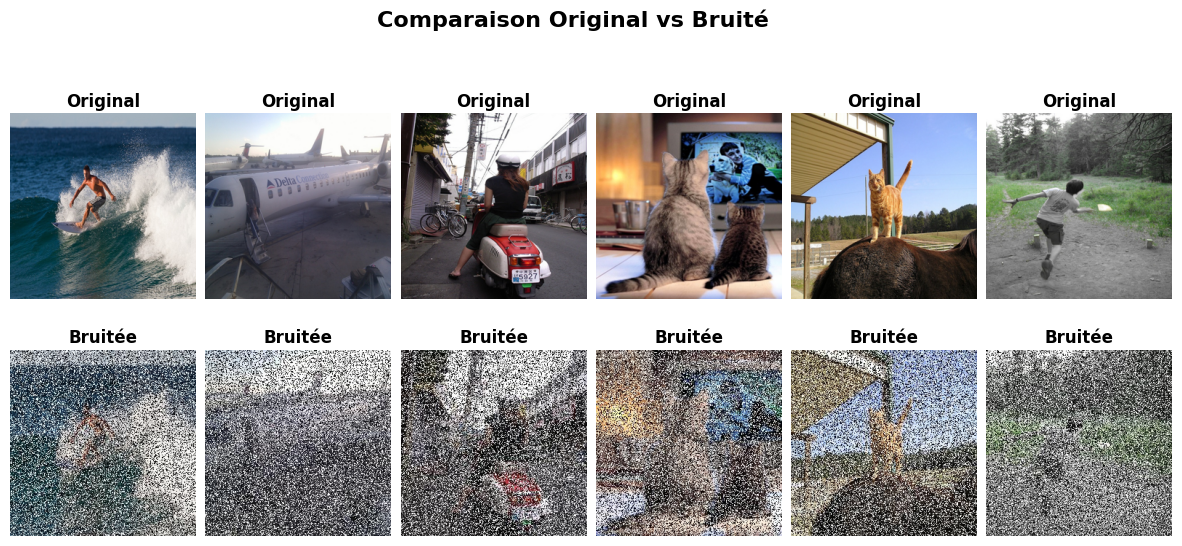

In [ ]:
import matplotlib.gridspec as gridspec

def show_comparison_grid(original_dir, noisy_dir, n=5, image_size=(256, 256), titles=True):
    """
    Affiche une grille stylisée de comparaison Original vs Bruité.
    """
    # Obtenir les noms communs d'images
    image_files = sorted([f for f in os.listdir(original_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])[:n]

    fig = plt.figure(figsize=(n * 2.5, 6))  # Largeur ajustée à n, hauteur fixe
    gs = gridspec.GridSpec(2, n, wspace=0.05, hspace=0.05)

    for i, filename in enumerate(image_files):
        # Chargement des deux images
        orig_path = os.path.join(original_dir, filename)
        noisy_path = os.path.join(noisy_dir, filename)

        orig = Image.open(orig_path).resize(image_size)
        noisy = Image.open(noisy_path).resize(image_size)

        # Subplot Original
        ax1 = fig.add_subplot(gs[0, i])
        ax1.imshow(orig)
        ax1.axis('off')
        if titles:
            ax1.set_title("Original", fontsize=12, weight='bold', pad=5)

        # Subplot Bruitée
        ax2 = fig.add_subplot(gs[1, i])
        ax2.imshow(noisy)
        ax2.axis('off')
        if titles:
            ax2.set_title("Bruitée", fontsize=12, weight='bold', pad=5)

        # Style optionnel : bordure légère autour des images
        for ax in [ax1, ax2]:
            for spine in ax.spines.values():
                spine.set_edgecolor('gray')
                spine.set_linewidth(0.5)

    fig.suptitle("Comparaison Original vs Bruité", fontsize=16, weight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

show_comparison_grid(
    original_dir=os.path.join(TARGET_PROCESSED_DIR, "clean"),
    noisy_dir=os.path.join(TARGET_PROCESSED_DIR, "noisy"),
    n=6
)

